In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional
from torchvision import datasets, transforms, models

from collections import OrderedDict
import csv 
import numpy as np
import pandas as pd

# **Parameters of Opacus**

In [ ]:
!pip install opacus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 4.9 MB/s 


In [ ]:
import warnings
warnings.simplefilter("ignore")

MAX_GRAD_NORM = 1.2
EPSILON = 1.0
DELTA = 1e-5
EPOCHS = 2

LR = 1e-3

In [ ]:
# BATCH_SIZE = 512
# MAX_PHYSICAL_BATCH_SIZE = 128
BATCH_SIZE = 128
MAX_PHYSICAL_BATCH_SIZE = 8

# **Get the Owner's Dataset**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
                               transforms.Resize(size=32),
                               transforms.Grayscale(num_output_channels=3),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
                             ])

In [ ]:
from torchvision.datasets import MNIST

num_of_training_samples=60000
num_of_testing_samples=10000

DATA_ROOT = '/files/'

train_dataset = torchvision.datasets.MNIST(DATA_ROOT, train=True, download=True,
                             transform=transform
                             )

test_dataset = torchvision.datasets.MNIST(DATA_ROOT, train=False, download=True,
                             transform=transform
                             )

train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=BATCH_SIZE,
  # batch_size=1,
  shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=BATCH_SIZE, 
  # batch_size=1,
  shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



torch.Size([3, 32, 32])
tensor(3)


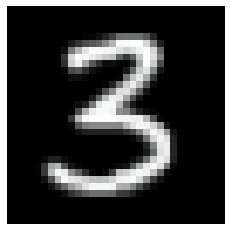

In [ ]:
## load helper.py
import helper
sample = iter(train_loader)
sample_img, sample_target = next(sample)
print(sample_img[0,:].shape)
helper.imshow(sample_img[0,:]);
print(sample_target[0])

# **Setup Vgg16 model**

Setup without Classifier

In [ ]:
# vgg_pretrained = models.vgg16(pretrained=True)

In [ ]:
# vgg_pretrained

In [ ]:
class VGG16(torch.nn.Module):
  def __init__(self,pretrained=True):
    super(VGG16, self).__init__()

    # features layers:
    vgg_pretrained_features = models.vgg16(pretrained=True).features
    self.features = torch.nn.Sequential()
    for i in range(31):
      # print(vgg_pretrained_features[i])
      self.features.add_module(str(i), vgg_pretrained_features[i])

    # avgpool layer:
    self.avgpool = models.vgg16(pretrained=True).avgpool

    # # fully conected layers:
    # self.fc6 = nn.Linear(7*7*512, 4096)
    # self.fc7 = nn.Linear(4096, 4096)
    # self.fc8 = nn.Linear(4096, 1000)

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    return x
    

In [ ]:
vgg16 = VGG16()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
features_model=vgg16
num_output_features=7*7*512
features_model

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [ ]:
for param in features_model.parameters():
    features_model.requires_grad = False
features_model.eval();

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
features_model = features_model.to(device)

cpu


# **Get The Features & Labels of training set for Data Scientist** 


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !mkdir ../content/drive/MyDrive/ColabNotebooks/FinalProject/train/
# num_of_TRfiles=num_of_training_samples
# pathTr=[]
# for f in range(num_of_TRfiles):
#   pathTr.append("../content/drive/MyDrive/ColabNotebooks/FinalProject/train/featuresAndLabels_training{}.npy".format(f))

mkdir: cannot create directory ‘../content/drive/MyDrive/ColabNotebooks/FinalProject/train/’: File exists


In [ ]:
!mkdir ../content/train/
num_of_TRfiles=num_of_training_samples
pathTr=[]
for f in range(num_of_TRfiles):
  pathTr.append("../content/train/featuresAndLabels_training{}.npy".format(f))

In [ ]:
#num_of_training_samples=60000
num_of_files=len(pathTr)
# num_of_batches_in_one_file= int(int(num_of_training_samples / BATCH_SIZE) /  num_of_files)
num_of_batches_in_one_file= int(int(num_of_training_samples / 1) /  num_of_files)

print ("num_of_batches_in_one_file: ", num_of_batches_in_one_file)
dl_iter=iter(train_loader)
# j=0

with torch.no_grad():
  features_model.eval()
  num_of_file=0  
  while(num_of_file<num_of_files):
    j=0
    while( (j) % num_of_batches_in_one_file != 0 or num_of_file==len(pathTr)-1 or j==0):
        try:
          images, target = next(dl_iter)
        except StopIteration:
          break
        # print("j=",j)
        images = images.to(device)
        target = target.to(device)
        
        target = target.cpu().detach().numpy()
        target=np.expand_dims(target, axis=0)
        
        pridict = features_model(images)
        pridict= pridict.cpu().detach().numpy()
        pridict= np.squeeze(pridict,axis=None)
        featuresAndLabels=np.concatenate((pridict, target.T), axis=1)###simulate it to sure validation of concatenate
        # featuresAndLabels=np.concatenate((pridict, target))
        # print(featuresAndLabels.shape[0])
        for i in range(featuresAndLabels.shape[0]):
            np.save(pathTr[num_of_file], featuresAndLabels[i:i+1,:])
            num_of_file = num_of_file + 1
            if((num_of_file)%5000==0):
              print("move to file:" , num_of_file)
              # break          
        j+=1

        

num_of_batches_in_one_file:  1
move to file: 5000
move to file: 10000
move to file: 15000
move to file: 20000
move to file: 25000
move to file: 30000
move to file: 35000
move to file: 40000
move to file: 45000
move to file: 50000
move to file: 55000
move to file: 60000


In [ ]:
# !cp -r ../content/train/ ../content/drive/MyDrive/ColabNotebooks/FinalProject

In [ ]:
# y=np.load(pathTr[0])
# y.shape

# **Get The Features & Labels of testing set for Data Scientist** 


In [ ]:
# !mkdir ../content/drive/MyDrive/ColabNotebooks/FinalProject/test/
# num_of_TSfiles=num_of_testing_samples
# pathTs=[]
# for f in range(num_of_TSfiles):
#   pathTs.append("../content/drive/MyDrive/ColabNotebooks/FinalProject/test/featuresAndLabels_testing{}.npy".format(f))

In [ ]:
!mkdir ../content/test/
num_of_TSfiles=num_of_testing_samples
pathTs=[]
for f in range(num_of_TSfiles):
  pathTs.append("../content/test/featuresAndLabels_testing{}.npy".format(f))

In [ ]:
num_of_files=len(pathTs)
#num_of_testing_samples=10000
# num_of_batches_in_one_file= int(int(num_of_testing_samples / BATCH_SIZE) /  num_of_files)
num_of_batches_in_one_file= int(int(num_of_testing_samples / 1) /  num_of_files)

print ("num_of_batches_in_one_file: ", num_of_batches_in_one_file)
dl_iter=iter(test_loader)
# j=0

with torch.no_grad():
  features_model.eval()
  num_of_file=0  
  while(num_of_file<num_of_files):
    j=0
    while( (j) % num_of_batches_in_one_file != 0 or num_of_file==len(pathTs)-1 or j==0):
        try:
          images, target = next(dl_iter)
        except StopIteration:
          break
        # print("j=",j)
        images = images.to(device)
        target = target.to(device)
        
        target = target.cpu().detach().numpy()
        target=np.expand_dims(target, axis=0)
        
        pridict = features_model(images)
        pridict= pridict.cpu().detach().numpy()
        pridict= np.squeeze(pridict,axis=None)
        featuresAndLabels=np.concatenate((pridict, target.T), axis=1)###simulate it to sure validation of concatenate
        # featuresAndLabels=np.concatenate((pridict, target))

        for i in range(featuresAndLabels.shape[0]):
            np.save(pathTs[num_of_file], featuresAndLabels[i:i+1,:])
            num_of_file = num_of_file + 1
            if((num_of_file)%5000==0):
              print("move to file:" , num_of_file)
        j+=1 

num_of_batches_in_one_file:  1
move to file: 5000
move to file: 10000


In [ ]:
# !cp -r ../content/test ../content/drive/MyDrive/ColabNotebooks/FinalProject

In [ ]:
features_model = features_model.to("cpu")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import os
import pandas as pd
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
)  # Gives easier dataset managment and creates mini batches

In [ ]:
class featuresAndLabels(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.num_of_files = len(self.path)
        self.transform = transform
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.len_dataset = len(self.path)
        self.num_of_batches_in_one_file = int(int(self.len_dataset / 1) /  self.num_of_files)
        print("init, ", "len_dataset= ", self.len_dataset , " in " , self.num_of_files ," files")
       


    def __len__(self):
        print("I count the length")
        if (self.len_dataset % 1 == 0):
          return ((int(self.len_dataset / 1))) #to keep in range of data by dataset_batch_size
        else:
          return ((int(self.len_dataset / 1)) + 1) #to take all data after last_index


    def __getitem__(self, index):
        n_of_file = index
        row = np.load(self.path[n_of_file]) # skip all data before index
        # row = torch.from_numpy(row).float().to(self.device)
        row = torch.from_numpy(row).float()
        row = torch.squeeze(row)
        image= row[:-1]
        y_label = row[-1:]
        return (image, y_label)



## Load Data

In [ ]:
featuresAndLabels_training_dataset = featuresAndLabels(path=pathTr)

init,  len_dataset=  60000  in  60000  files


In [ ]:
featuresAndLabels_testing_dataset = featuresAndLabels(path=pathTs)

init,  len_dataset=  10000  in  10000  files


In [ ]:
# y=[]
# for i in range(128):
#   y.append(featuresAndLabels_training_dataset.__getitem__(i))

In [ ]:
train_features_loader = torch.utils.data.DataLoader(
    featuresAndLabels_training_dataset,
    batch_size=BATCH_SIZE,
    # batch_size=1,
    shuffle=True,
)

test_features_loader = torch.utils.data.DataLoader(
    featuresAndLabels_testing_dataset,
    batch_size=BATCH_SIZE,
    # batch_size=1,
    shuffle=True,
)

I count the length
I count the length
I count the length
I count the length


## **Setup The Classifier model**

In [ ]:
in_dim = num_output_features
out_dim = 10

class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__() 
        # self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(in_dim, 4096)
        # self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, out_dim)
        self.dropout =  nn.Dropout(p=0.2)

    def forward(self, x):
      # x = self.avgpool(x)
      x = self.fc1(x)
      x = torch.sigmoid(x)
      x = self.dropout(x)


      # x = self.fc2(x)
      # x = nn.functional.relu(x)
      # x = self.dropout(x)

      output = self.fc3(x)
      # x = nn.functional.log_softmax(x)
      # x = self.dropout(x)

      # output = nn.functional.sigmoid(x)

      # output = nn.functional.log_softmax(x, dim=1)
      return output

In [ ]:
classifier_model_noPrivate = Classifier()
classifier_model_noPrivate

Classifier(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
import opacus
from opacus.validators import ModuleValidator

errors = ModuleValidator.validate(classifier_model_noPrivate, strict=False)
errors[-5:]

[]

In [ ]:
classifier_model_noPrivate = ModuleValidator.fix(classifier_model_noPrivate)
ModuleValidator.validate(classifier_model_noPrivate, strict=False)

[]

In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
opt_c_noPrivate = optim.RMSprop(classifier_model_noPrivate.parameters(), lr=LR)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device="cpu"
print(device)
classifier_model_noPrivate = classifier_model_noPrivate.to(device)

cpu


In [ ]:
def accuracy(preds, labels):
    return (preds == labels).mean()

## **Setup The Privacy Engine**

In [ ]:
from opacus import PrivacyEngine

privacy_engine = PrivacyEngine()

modelDP, optimizerDP, train_loaderDP = privacy_engine.make_private_with_epsilon(
    module=classifier_model_noPrivate,
    optimizer=opt_c_noPrivate,
    data_loader=train_features_loader,
    epochs=EPOCHS,
    target_epsilon=EPSILON,
    target_delta=DELTA,
    max_grad_norm=MAX_GRAD_NORM,
)

print(f"Using sigma={optimizerDP.noise_multiplier} and C={MAX_GRAD_NORM}")

I count the length
I count the length
I count the length
I count the length
Using sigma=0.9228515625 and C=1.2


In [ ]:
# print(train_features_loader) #train_loader with no private
print(train_loaderDP)

In [ ]:
# print(classifier_model_noPrivate) #train_loader with no private
print(modelDP)

GradSampleModule(Classifier(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
))


In [ ]:
# print(opt_c_noPrivate) #optimizer with no private
print(optimizerDP )

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)


In [ ]:
test_features_loader

### Training loop function:


In [ ]:
torch.cuda.empty_cache()

In [ ]:
#final
import numpy as np
from opacus.utils.batch_memory_manager import BatchMemoryManager


def train_Private(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.NLLLoss()

    losses = []
    top1_acc = []
    
    with BatchMemoryManager(
        data_loader=train_loader, 
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE, 
        optimizer=optimizer
    ) as memory_safe_data_loader:

        for i, (images,target) in enumerate(memory_safe_data_loader):   
            optimizer.zero_grad()

            if images.shape[0]!=1:
              images = torch.squeeze(images)

            target = target.type(torch.LongTensor)
            if target.shape[0]==1:
              target = target[0]
            else:
              target = torch.squeeze(target)

            print("images.shape: ")
            print(images.shape)
            print("target.shape: ")
            print(target.shape)
            images = images.to(device)
            target = target.to(device)

            # compute output
            # model = model.to(device)
            output = model(images.float())
            # output = model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            # preds = output.detach().cpu().numpy()
            labels = target.detach().cpu().numpy()
            
            # measure accuracy and record loss
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

            

            loss.backward()
            optimizer.step()

            if (i+1) % 1 == 0:
                epsilon = privacy_engine.get_epsilon(DELTA)
                print(
                    f"\tTrain Epoch: {epoch} \t"
                    f"Loss: {np.mean(losses):.6f} "
                    f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
                    f"(ε = {epsilon:.2f}, δ = {DELTA})"
                )
            # torch.cuda.empty_cache()

### Testing loop function:


In [ ]:
def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.NLLLoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for (images,target) in test_loader:
            images = torch.squeeze(images)
            target = target.type(torch.LongTensor)
            target = torch.squeeze(target)

            images = images.to(device)
            target = target.to(device)

            output = model(images.float())
            # output = model(images)
            loss = criterion(output, target)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            # preds = output.detach().cpu().numpy()
            labels = target.detach().cpu().numpy()
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)

    print(
        f"\tTest set:"
        f"Loss: {np.mean(losses):.6f} "
        f"Acc: {top1_avg * 100:.6f} "
    )
    return np.mean(top1_acc)

## Training loop:

In [ ]:
## Epoch: 2 , BATCH_SIZE = 128 , MAX_PHYSICAL_BATCH_SIZE = 8
from tqdm.notebook import tqdm

for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
    train_Private(modelDP, train_loaderDP, optimizerDP, epoch + 1, device)

## Testing Loop:

In [ ]:
top1_acc = test(classifier_model_noPrivate, test_features_loader, device)

I count the length
I count the length
I count the length
	Test set:Loss: 0.510249 Acc: 84.048655 


## **Save model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
classifier_model_noPrivate = classifier_model_noPrivate.to("cpu")

In [ ]:
PathClassifier='../content/drive/MyDrive/finalProjectColab/classifier_model_Version_Private1.pt'
torch.save(classifier_model_noPrivate, PathClassifier)

## **Load model**

In [ ]:
PathClassifier='../content/drive/MyDrive/finalProjectColab/classifier_model_Version_Private1.pt'
classifier_ = torch.load(PathClassifier)

## **Classification**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
features_model = features_model.to(device)
modelDP = modelDP.to(device)
features_model.eval()
modelDP.eval()

cuda


GradSampleModule(Classifier(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
))

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
                               transforms.Resize(size=224),
                               transforms.Grayscale(num_output_channels=3),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
                             ])

torch.Size([3, 224, 224])
tensor(5)


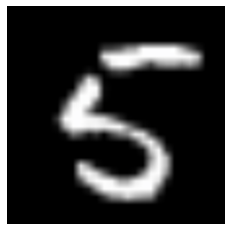

In [ ]:
## load helper.py
import helper
sample = iter(test_loader)
sample_img, sample_target = next(sample)
print(sample_img[0,:].shape)
testImg = sample_img[0,:]
helper.imshow(testImg);
print(sample_target[0])
img =testImg

In [ ]:
with torch.no_grad():

  # img1 =transform(img) # set this if you load image not by testloader
  img1 =img # set this if you load image by testloader
  
  print(img1.shape)
  img1 = torch.unsqueeze(img1, 0)
  print(img1.shape)
  img1 = img1.to(device)
  pred = features_model(img1)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [ ]:
with torch.no_grad():
  pred = torch.squeeze(pred)
  pred.shape
  result = modelDP(pred.float())
  preds = np.argmax(result.detach().cpu().numpy())
  print(preds)
  print(result)
  # 0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9

5
tensor([-1.4219, -4.4577, -3.6013,  2.1117, -0.9454, 12.0823,  0.2504, -3.8526,
         2.6971, -3.2288], device='cuda:0')


## **Attack**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Attacker(nn.Module):
  def __init__(self):
    super(Attacker, self).__init__()
    self.layers= nn.Sequential(
                      nn.Linear(10, 512),
                      nn.ReLU(),
                      nn.Linear(512, 1000),
                      nn.ReLU(),
                      nn.Linear(1000, 1000),
                      nn.ReLU(),
                      nn.Linear(1000, 1024),
                    )
 
  def forward(self, x):
    return self.layers(x)

In [ ]:
attacker = Attacker()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device="cpu"
print(device)
attacker = attacker.to(device)

cpu


In [ ]:
PathClassifier='../content/drive/MyDrive/finalProjectColab/Version_Private_attacker_1.pt'
attacker = torch.load(PathClassifier)

In [ ]:
classifier_ = classifier_model_noPrivate

torch.Size([3, 32, 32])
tensor(5)
torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])
1
tensor([-0.1236,  0.6877, -0.1889,  0.4258,  0.3086, -0.3182, -0.0254,  0.3893,
        -0.2033, -0.4359])
torch.Size([1024])
torch.Size([1, 32, 32])


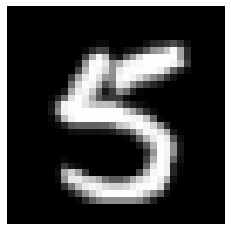

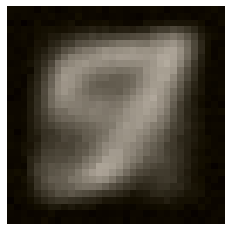

In [ ]:
## load helper.py
import helper
sample = iter(test_loader)
sample_img, sample_target = next(sample)
print(sample_img[0,:].shape)
testImg = sample_img[0,:]
helper.imshow(testImg);
print(sample_target[0])
img =testImg

with torch.no_grad():

  # img1 =transform(img) # set this if you load image not by testloader
  img1 =img # set this if you load image by testloader
  
  print(img1.shape)
  img1 = torch.unsqueeze(img1, 0)
  print(img1.shape)
  img1 = img1.to(device)
  pred = features_model(img1)

with torch.no_grad():
  pred = torch.squeeze(pred)
  pred.shape
  result = classifier_(pred.float())
  preds = np.argmax(result.detach().cpu().numpy())
  print(preds)
  print(result)

with torch.no_grad():
  attacker = attacker.to(device)
  recreate = attacker(result)

  print(recreate.shape)
  recreate1 = recreate.reshape([1,32,32])
  print(recreate1.shape)
  recreate2=recreate1.to("cpu")
  helper.imshow(recreate2)
  # plt.imshow(recreate2[0],"gray")